In [1]:
from utils_project import *

from transformers import pipeline
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def pairwise_annak_distances(X):
    n = len(X)
    annak_sim = np.zeros((n, n))
    X_rank = scipy.stats.rankdata(X) 
    for i in range(n):
        for j in range(n):
            if i < j:
                annak_sim[i,j] = annak_sim[j,i] = np.mean([X_rank[i], X_rank[j]]) / n
            elif i==j:
                annak_sim[i,j] = 1
    annak_dist = 1 - annak_sim
    return annak_dist

def get_sentiments(free_resps, preprocess=True):

    if isinstance(free_resps, np.ndarray):
        free_resps = free_resps.tolist()
    if preprocess:
        free_resps = [preprocess_text(fr, remove_stopwords=False, return_tokenized=False) for fr in free_resps]

    sentiments = {}
    for role, response in zip(character_roles, free_resps):
        try:
            sentiment_scores = SentimentIntensityAnalyzer().polarity_scores(response)
            sentiments.update({
                f'positive_{role}': sentiment_scores['pos'],
                f'negative_{role}': sentiment_scores['neg'],
                f'neutral_{role}': sentiment_scores['neu'],
                f'compound_{role}': sentiment_scores['compound']
            })
        except:
            keys = ['positive', 'negative', 'neutral', 'compound']
            sentiments.update({f'{key}_{role}': np.nan for key in keys})
    return sentiments

Initial n=579
Validation n=255
Combined n=834
Questionnaire items loaded


In [2]:
data_val   = sample_dict['Validation']['data']
ques_items = subset_df(data_val, fa_prefixes).iloc[:, 1:]

# get semantic features
data_dir  = f'{base_dir}/Data'
out_fname = f'{data_dir}/semantic_dict.pkl'

if os.path.exists(out_fname):
    
    semantic_dict = load_pickle(out_fname)

else:

    semantic_dict = {sub_id: {} for sub_id in data_val['sub_id'].values}

    for r, row in data_val.iterrows():

        sub_id     = row['sub_id']
        free_resps = row[[f'free_response_{role}' for role in character_roles]].values

        # sentiments & number of words
        semantic_dict[sub_id]['sentiments'] = pd.DataFrame(get_sentiments(free_resps, preprocess=True), index=[0])
        num_words_ = np.array([len(fr.split(" ")) for fr in free_resps])[np.newaxis,:]
        semantic_dict[sub_id]['num_words'] = pd.DataFrame(num_words_, columns=[f'num_words_{role}' for role in character_roles], index=[0])

        # get embeddings 
        semantic_dict[sub_id]['mlml12_embeddings']   = get_sentencetransformer_embeddings(free_resps, model='mlml12')
        semantic_dict[sub_id]['mpnet_embeddings']    = get_sentencetransformer_embeddings(free_resps, model='mpnet')
        semantic_dict[sub_id]['roberta_embeddings']  = get_sentencetransformer_embeddings(free_resps, model='roberta')
        semantic_dict[sub_id]['multi_qa_embeddings'] = get_sentencetransformer_embeddings(free_resps, model='multi_qa')
    
    pickle_file(semantic_dict, out_fname)

include_neutral = True
nchar = 6 if include_neutral else 5
sub_ids = semantic_dict.keys()

# number of words
num_words = np.array([semantic_dict[sub_id]['num_words'] for sub_id in sub_ids]).squeeze()
num_words = pd.DataFrame(num_words[:,:nchar], columns=[f'num_words_{role}' for role in character_roles[:nchar]])
data_val.loc[:, num_words.columns] = num_words
data_val['num_words_mean'] = np.mean(data_val[[f'num_words_{role}' for role in character_roles[:nchar]]], axis=1)

# sentiment analsysi
sentiments = pd.concat([semantic_dict[sub_id]['sentiments'] for sub_id in sub_ids]).reset_index(drop=True)
data_val.loc[:, sentiments.columns] = sentiments
data_val['positive_mean'] = np.mean(data_val[[f'positive_{role}' for role in character_roles[:nchar]]], axis=1)
data_val['negative_mean'] = np.mean(data_val[[f'negative_{role}' for role in character_roles[:nchar]]], axis=1)
data_val['neutral_mean']  = np.mean(data_val[[f'neutral_{role}' for role in character_roles[:nchar]]], axis=1)
data_val['compound_mean'] = np.mean(data_val[[f'compound_{role}' for role in character_roles[:nchar]]], axis=1)

# Embedding dissimilarities correlate with behavioral and subjective dissimilarities
Nice as a validation since it's unstructured - and kind of opens door to more NLP-like analyses of the fMRI data

RSA Wilcoxon: W=18405.0, right-tailed p=0.003
RSA Wilcoxon: W=21613.5, right-tailed p=0.000
Correlation between taus: tau=0.096, right-tailed p=0.012



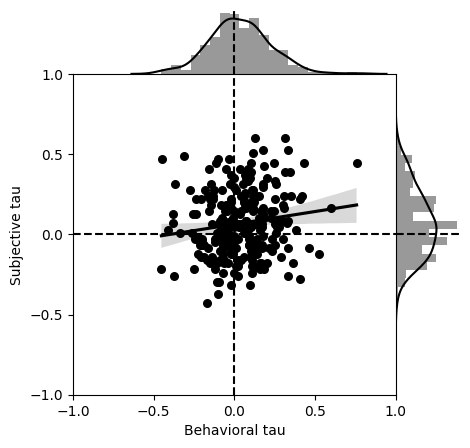

In [3]:
def plot_(x, y, 
          figsize=(5,5), 
          ax=None, color='grey', 
          density=False, regression=False):
    
    '''
    '''

    if density:
        xy = np.vstack([x, y])
        z  = gaussian_kde(xy)(xy)  # calculate the point density
        idx = z.argsort() # sort so that the bright spots are on top
        x, y, z = x[idx], y[idx], z[idx]

    # plot
    fig, axs = plt.subplots(2, 2, figsize=figsize, 
                            gridspec_kw={'hspace': 0, 'wspace': 0,
                                        'width_ratios': [5, 1], 'height_ratios': [1, 5]})
    axs[0,0].axis("off")
    axs[0,1].axis("off")
    axs[1,1].axis("off")
    axs[1,0].set_ylim([-1,1])
    axs[1,0].set_yticks([-1,-.5,0,.5,1])
    axs[1,0].set_xlim([-1,1])
    axs[1,0].set_xticks([-1,-.5,0,.5,1])
    axs[1,0].axhline(y=0, color='black', linestyle='--', zorder=-1)
    axs[1,0].axvline(x=0, color='black', linestyle='--', zorder=-1)

    sns.distplot(x, bins=20, ax=axs[0,0], color=color)
    axs[0,0].set_xlim([-1,1])
    axs[0,0].axvline(x=0, color='black', linestyle='--', zorder=-1)
    sns.distplot(y, bins=20, ax=axs[1,1], color=color, vertical=True)
    axs[1,1].set_ylim([-1,1])
    axs[1,1].axhline(y=0, color='black', linestyle='--', zorder=-1)

    if density:
        axs[1,0].scatter(x, y, c=z, s=100)
    else:
        axs[1,0].scatter(x, y, color=color, s=30)

    if regression: 
        sns.regplot(x=x, y=y, scatter=False, color='black', ax=axs[1,0])
    
    return axs

# compute correlations
semantic_rdvs = [symm_mat_to_ut_vec(pairwise_distances(embd[:nchar,:], metric='cosine')) for embd in [semantic_dict[sub_id]['mlml12_embeddings'] for sub_id in sub_ids]]
beh_rdvs      = [symm_mat_to_ut_vec(pairwise_distances(xys, metric='euclidean')) for xys in get_coords(data_val, which='task', include_neutral=include_neutral)]
dots_rdvs     = [symm_mat_to_ut_vec(pairwise_distances(xys, metric='euclidean')) for xys in get_coords(data_val, which='dots', include_neutral=include_neutral)]
taus = np.array([[kendalltau(semantic_rdvs[i], beh_rdvs[i])[0], kendalltau(semantic_rdvs[i], dots_rdvs[i])[0]] for i in range(len(semantic_rdvs))])

axs = plot_(taus[:,0], taus[:,1], color="black", regression=True) # sample_colors[1]
axs[1,0].set_xlabel('Behavioral tau')
axs[1,0].set_ylabel('Subjective tau');

taus = np.array(taus)
for i, taus_ in enumerate(taus.T):
    W, p = wilcoxon(isfinite(taus_)[0], alternative='greater')
    print(f'RSA Wilcoxon: W={W}, right-tailed p={p:.3f}')
tau, p = kendalltau(taus[:,0], taus[:,1], alternative='greater')
print(f'Correlation between taus: tau={tau:.3f}, right-tailed p={p:.3f}\n')

# Sentiment varies over the characters
The boss is clearly in a different category than the other characters...

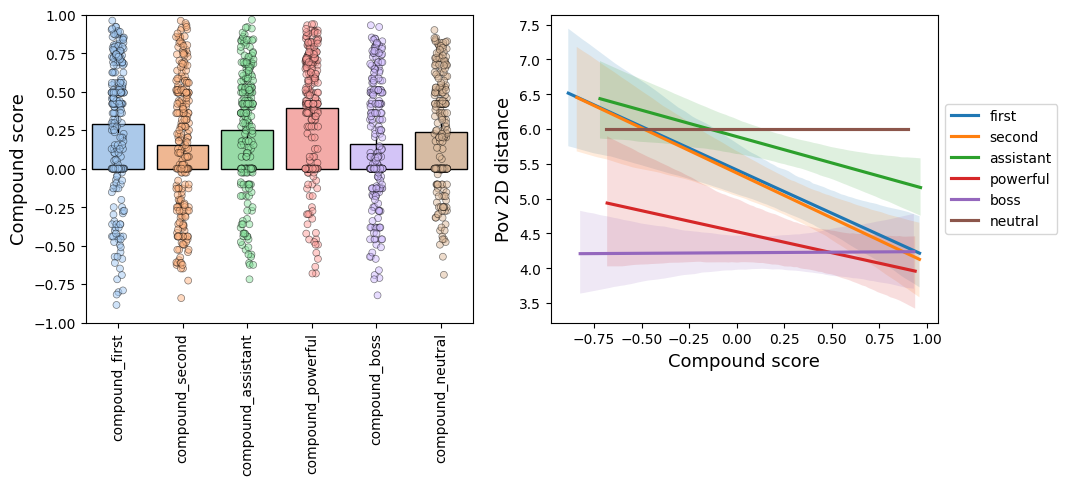

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(11, 4))

ax = axs[0]
sns.barplot(data=data_val[[f'compound_{role}' for role in character_roles[:nchar]]], 
            palette='pastel', edgecolor='black', errcolor='black', errwidth=1, 
            ax=ax)
sns.stripplot(data=data_val[[f'compound_{role}' for role in character_roles[:nchar]]], 
              palette='pastel', alpha=0.5, edgecolor='black', linewidth=0.5,
              ax=ax)
ax.set_ylabel('Compound score', fontsize=label_fontsize)
ax.set_ylim(-1, 1)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

ax = axs[1]
for role in character_roles[:nchar]:
    sns.regplot(data=data_val, x=f'compound_{role}', y=f'pov_2d_dist_{role}', scatter=False, ax=ax, label=role)
ax.set_xlabel('Compound score', fontsize=label_fontsize)
ax.set_ylabel('Pov 2D distance', fontsize=label_fontsize)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

# Negative sentiments
- social network size, pov dist, social factor and mood are all associated w/ sentiment 
    - no significant relationship with affiliation or power, but trends... another example of how collapsing into pov dist might improve interpretability
- number of words positively associated: more happy, more writing


- TODO other things to try
    - does pov distance have an anna karenina kind of thing going on? or some other structure we can probe with IS-RSA

,x,dof,adj_rsq,bic,aic,beta,se,95%_lb,95%_ub,t,p,p_left,p_right
1,pov_2d_dist_mean_mean,228.0,0.153,803.24,707.63,-0.1453,0.0637,-0.2709,-0.0198,-2.2807,2.3491e-02,0.0117,9.8825e-01
2,factor_social_quartimax_thresh25,228.0,0.153,803.24,707.63,-0.0656,0.0624,-0.1885,0.0572,-1.0526,2.9366e-01,0.1468,8.5317e-01
3,factor_mood_quartimax_thresh25,228.0,0.153,803.24,707.63,-0.1088,0.0626,-0.2322,0.0145,-1.7386,8.3458e-02,0.0417,9.5827e-01
4,factor_compulsive_quartimax_thresh25,228.0,0.153,803.24,707.63,0.0108,0.0644,-0.1161,0.1376,0.1672,8.6737e-01,0.5663,4.3369e-01
5,num_words_mean,228.0,0.153,803.24,707.63,0.3978,0.0653,0.2692,0.5264,6.0941,4.6461e-09,1.0000,2.3231e-09


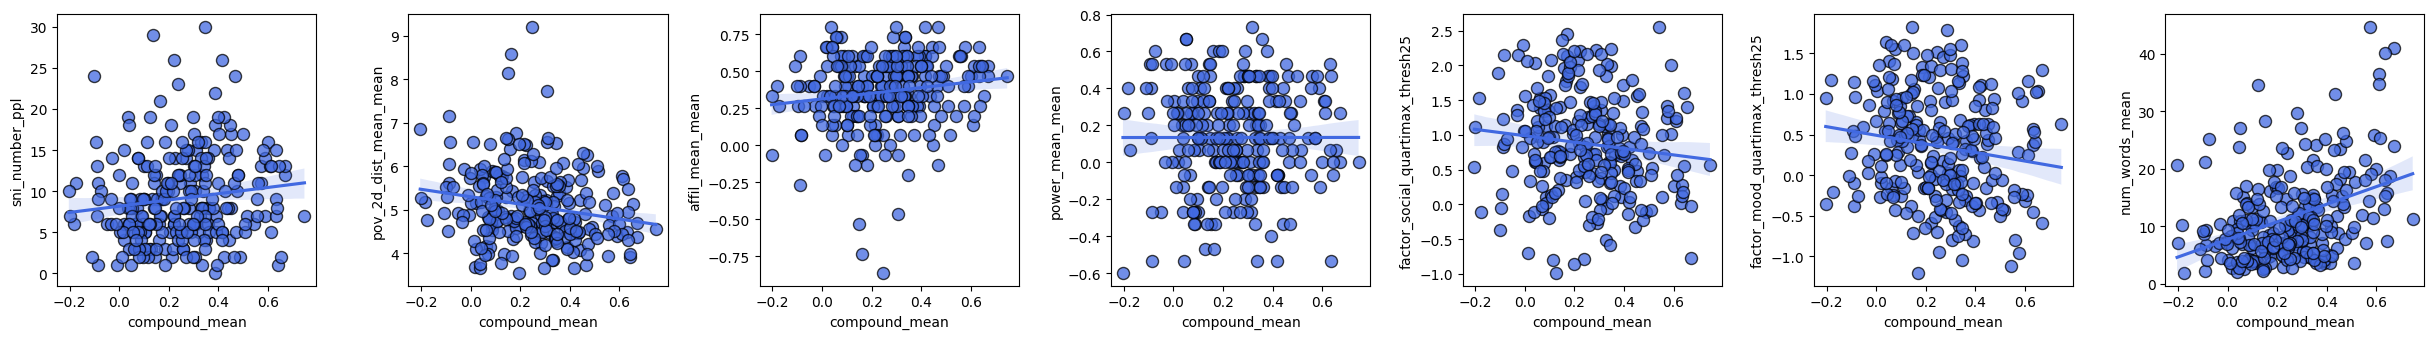

In [5]:
# plot individually
yvars = ['sni_number_ppl', 'pov_2d_dist_mean_mean', 'affil_mean_mean', 'power_mean_mean', social_factor, mood_factor, 'num_words_mean'] # 
fig, axs = plt.subplots(1, len(yvars), figsize=(3.5*len(yvars), 3.5))
for i, yvar in enumerate(yvars):
    plot_regplot(data_val['compound_mean'], data_val[yvar], color=sample_colors[1], ax=axs[i])
plt.tight_layout()

# run ols
xvars   = ['pov_2d_dist_mean_mean', social_factor, mood_factor, compulsive_factor, 'num_words_mean', 'memory_mean']
results = run_ols(X=xvars, y='compound_mean', data=data_val,  covariates=all_controls)[0]
display(results[results['x'].isin(xvars)].iloc[:,2:])

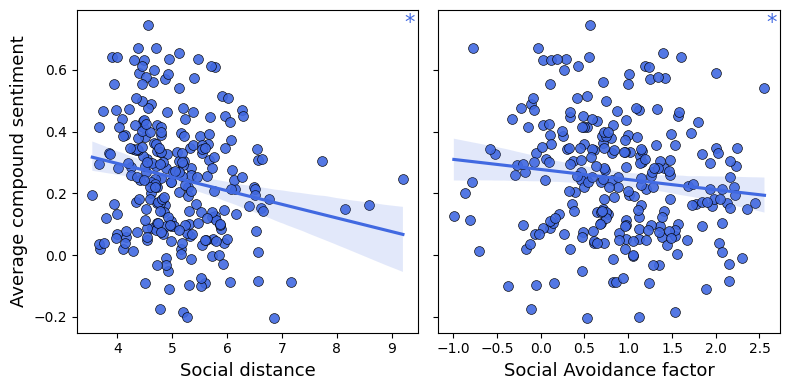

In [6]:
fig, axs = plt.subplots(1,2, figsize=(8, 4), sharey=True)

ax = axs[0]
sns.regplot(data=data_val, x='pov_2d_dist_mean_mean', y='compound_mean', scatter=True,
            scatter_kws={'alpha':0.9, 's':50, 'edgecolor': 'black', 'linewidth':0.5},
            color=sample_colors[1], ax=ax)
ax.set_xlabel('Social distance', fontsize=label_fontsize)
ax.set_ylabel('Average compound sentiment', fontsize=label_fontsize)
plot_significance(ax, 0.019*2, sig_level=4, x=0.96, y=0.99, dx=-0.0275, color=sample_colors[1], fontsize=title_fontsize)

ax = axs[1]
sns.regplot(data=data_val, x=social_factor, y='compound_mean', scatter=True,
            scatter_kws={'alpha':0.9, 's':50, 'edgecolor': 'black', 'linewidth':0.5},
            color=sample_colors[1], ax=ax)
ax.set_xlabel('Social Avoidance factor', fontsize=label_fontsize)
ax.set_ylabel('', fontsize=label_fontsize)
plot_significance(ax, 0.0055*2, sig_level=4, x=0.96, y=0.99, dx=-0.0275, color=sample_colors[1], fontsize=title_fontsize)
plt.tight_layout()